In [1]:
from instant_ack import *

%load_ext autoreload
%autoreload 2

2024-09-11 00:12:41.226 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


In [2]:
m_improvement = {True: "Reduced Latency", False: "Spurious Retransmissions"}


def first_pto_improvement(
    iack_improvements=[1, 9, 25],
    start=0.025,
    stop=100,
    step=0.005,
):
    return pl.concat(
        [
            cv.get_theoretical_improvement(i, np.arange(start, stop + step, step))
            for i in iack_improvements
        ],
        how="vertical",
    ).with_columns(pl.col("improved").replace_strict(m_improvement))

In [3]:
cv.get_theoretical_improvement(
    9,
    np.arange(1, 3.2, 0.1),
)

rtt,pto,pto_improved,iack_improvement,improvement,improved,improvement_factor
f64,f64,f64,i32,f64,bool,f64
1.0,30.0,3.0,9,27.0,false,27.0
1.1,30.3,3.3,9,27.0,false,24.545455
1.2,30.6,3.6,9,27.0,false,22.5
1.3,30.9,3.9,9,27.0,false,20.769231
1.4,31.2,4.2,9,27.0,false,19.285714
…,…,…,…,…,…,…
2.7,35.1,8.1,9,27.0,false,10.0
2.8,35.4,8.4,9,27.0,false,9.642857
2.9,35.7,8.7,9,27.0,false,9.310345


### Reduced Latency vs. Spurious Retransmissions: Section 4, Figure 4

/tmp/ipykernel_3690/4001111083.py:40: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(


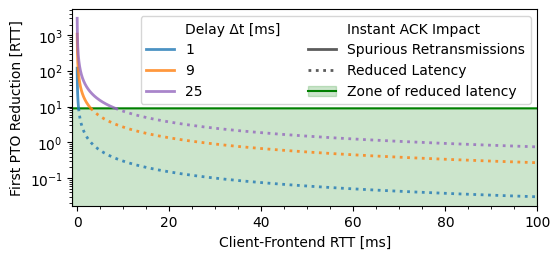

In [4]:
from matplotlib.patches import Patch, Rectangle


def plot_lin_theoretical_improvement_backend_delay(
    dest, yscale="lin", zone=True, figsize=None, **kwargs
):
    delta_t = "Delay Δt [ms]"
    first_pto = "PTO"
    improvement = "Instant ACK Impact"

    step = 0.005
    theos = first_pto_improvement(step=step).rename(
        {
            "iack_improvement": delta_t,
            "pto_improved": first_pto,
            "improved": improvement,
        }
    )

    fig, ax = vh.fig_ax(figsize)

    if zone:
        label = "Zone of reduced latency"
        sns.lineplot(
            x=np.arange(theos["rtt"].min() - 1, theos["rtt"].max() + step, step),
            y=9,
            color="green",
            label="Zone of reduced latency",
        )

        def fill_under_lines(ax=None, alpha=0.2, **kwargs):
            if ax is None:
                ax = plt.gca()
            for line in ax.lines:
                x, y = line.get_xydata().T
                ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)

        fill_under_lines()

    sns.lineplot(
        theos,
        x="rtt",
        y="improvement_factor",
        hue=delta_t,
        palette=sns.color_palette()[:2] + sns.color_palette()[4:],
        style=improvement,
        style_order=sorted(theos[improvement].unique(), reverse=True),
        alpha=0.8,
        linewidth=2,
    )

    # To plot, the area where we have an improvement, we need another axis, but we can approximare
    ax.lines[2].set_linestyle(":")
    ax.lines[4].set_linestyle(":")
    ax.lines[6].set_linestyle(":")

    handles, labels = ax.get_legend_handles_labels()

    handles[-1].set_linestyle(":")
    if zone:

        cur = handles[0]
        handles[0] = (
            Patch(color=cur.get_color(), alpha=0.2),
            cur,
        )

        ax.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], ncol=2)
    else:
        handles.append(Patch(color="none"))
        labels.append("")

        ax.legend(handles, labels, ncol=2)
    # ax.legend().remove()

    ax.set(yscale=yscale)
    ax.set(xlabel="Client-Frontend RTT [ms]")
    ax.set(ylabel="First PTO Reduction [RTT]")
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set(xlim=(-1, 100))
    vh.save_plot(fig, dest, autoclose=False)
    plt.show()
    return theos


yscale = "log"
fname = f"lin_theoretic_improvement_factors_{yscale},zone={True}"
theos = plot_lin_theoretical_improvement_backend_delay(
    fname, yscale=yscale, figsize=(6, 2.55)
)